# Tuning an estimator

[Peer Herholz (he/him)](https://peerherholz.github.io/)  
Research affiliate - [NeuroDataScience lab](https://neurodatascience.github.io/) at [MNI](https://www.mcgill.ca/neuro/)/[McGill](https://www.mcgill.ca/) (& [UNIQUE](https://sites.google.com/view/unique-neuro-ai)) & [Senseable Intelligence Group](https://sensein.group/) at [McGovern Institute for Brain Research](https://mcgovern.mit.edu/)/[MIT](https://www.mit.edu/)  
Member - [BIDS](https://bids-specification.readthedocs.io/en/stable/), [ReproNim](https://www.repronim.org/), [Brainhack](https://brainhack.org/), [Neuromod](https://www.cneuromod.ca/), [OHBM SEA-SIG](https://ohbm-environment.org/) 

<img align="left" src="https://raw.githubusercontent.com/G0RELLA/gorella_mwn/master/lecture/static/Twitter%20social%20icons%20-%20circle%20-%20blue.png" alt="logo" title="Twitter" width="32" height="20" /> <img align="left" src="https://raw.githubusercontent.com/G0RELLA/gorella_mwn/master/lecture/static/GitHub-Mark-120px-plus.png" alt="logo" title="Github" width="30" height="20" />   &nbsp;&nbsp;@peerherholz 

<img align="right" src="https://raw.githubusercontent.com/PeerHerholz/ML-DL_workshop_SynAGE/master/lecture/static/ml-dl_workshop.png" alt="logo" title="Github" width="400" height="280" />

### Aim(s) of this section 🎯

It's very important to learn when and where its appropriate to "tweak" your model.


Since we have done all of the previous analysis in our training data, it's fine to try out different models.

But we absolutely cannot "test" it on our *left out data*. If we do, we are in great danger of overfitting.

It is not uncommon to try other models, or tweak hyperparameters. In this case, due to our relatively small sample size, we are probably not powered sufficiently to do so, and we would once again risk overfitting. However, for the sake of demonstration, we will do some tweaking.

## Outline for this section 📝

- normalizing our target data
- tweaking our hyperparameters
- trying a more complicated model
- feature selection



### Prepare data for model

Lets bring back our example data set

In [1]:
import numpy as np
import pandas as pd

# get the data set
data = np.load('MAIN2019_BASC064_subsamp_features.npz')['a']

# get the labels
info = pd.read_csv('participants.csv')


print('There are %s samples and %s features' % (data.shape[0], data.shape[1]))

There are 155 samples and 2016 features


We'll set `Age` as target
- i.e., well look at these from the `regression` perspective

In [19]:
# set age as target
Y_con = info['Age']
Y_con.describe()

count    155.000000
mean      10.555189
std        8.071957
min        3.518138
25%        5.300000
50%        7.680000
75%       10.975000
max       39.000000
Name: Age, dtype: float64

### Model specification

Now let's bring back the model specifications we used last time

In [21]:
from sklearn.model_selection import train_test_split

# split the data
X_train, X_test, y_train, y_test = train_test_split(data, Y_con, random_state=0)

# use `AgeGroup` for stratification
age_class2 = info.loc[y_train.index,'AgeGroup']

### Normalize the target data¶

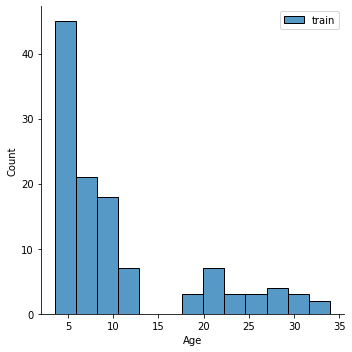

In [40]:
# plot the data
sns.displot(y_train,label='train')
plt.legend()

In [24]:
# create a log transformer function and log transform Y (age)
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(func = np.log, validate=True)
log_transformer.fit(y_train.values.reshape(-1,1))
y_train_log = log_transformer.transform(y_train.values.reshape(-1,1))[:,0]

Now let's plot the transformed data

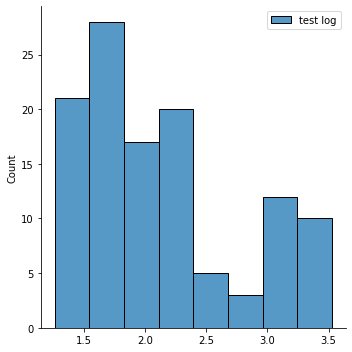

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.displot(y_train_log,label='test log')
plt.legend()

and go on with fitting the model to the log-tranformed data

In [44]:
# split the data
X_train2, X_test, y_train2, y_test = train_test_split(
    X_train, # x
    y_train, # y
    test_size = 0.25, # 75%/25% split  
    shuffle = True, # shuffle dataset before splitting
    stratify = age_class2,  # keep distribution of age class consistent
                            # betw. train & test sets.
    random_state = 0 # same shuffle each time
)

In [95]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error

# re-intialize the model
lin_svr = SVR(kernel='linear') 

# predict
y_pred = cross_val_predict(lin_svr, X_train, y_train_log, cv=10)

# scores
acc = r2_score(y_train_log, y_pred)
mae = mean_absolute_error(y_train_log,y_pred)

In [46]:
# check the accuracy
print('R2:', acc)
print('MAE:', mae)

R2: 0.6565364559090001
MAE: 0.27044306981575505


Text(0, 0.5, 'Log Age')

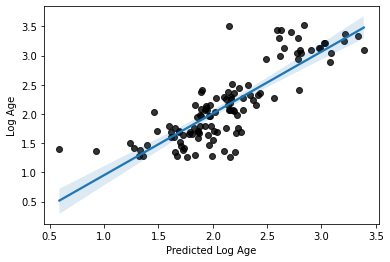

In [94]:
# plot the relationship
sns.regplot(x=y_pred, y=y_train_log, scatter_kws=dict(color='k'))
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

Alright, seems like a definite improvement, right? We might agree on that.

But we can't forget about interpretability? The MAE is much less interpretable now
- do you know why?


### Tweak the hyperparameters¶

Many machine learning algorithms have hyperparameters that can be "tuned" to optimize model fitting.

Careful parameter tuning can really improve a model, but haphazard tuning will often lead to overfitting.

Our SVR model has multiple hyperparameters. Let's explore some approaches for tuning them

for 1000 points, what is a parameter?

In [52]:
SVR?

Now, how do we know what parameter tuning does?

- One way is to plot a **Validation Curve**, this will let us view changes in training and validation accuracy of a model as we shift its hyperparameters. We can do this easily with sklearn.


We'll fit the same model, but with a range of different values for `C`
 - The C parameter tells the SVM optimization how much you want to avoid misclassifying each training example. For large values of C, the optimization will choose a smaller-margin hyperplane if that hyperplane does a better job of getting all the training points classified correctly. Conversely, a very small value of C will cause the optimizer to look for a larger-margin separating hyperplane, even if that hyperplane misclassifies more points. For very tiny values of C, you should get misclassified examples, often even if your training data is linearly separable.


In [91]:
from sklearn.model_selection import validation_curve



C_range = 10. ** np.arange(-3, 7)
train_scores, valid_scores = validation_curve(lin_svr, X_train, y_train_log, 
                                              param_name= "C",
                                              param_range = C_range,
                                              cv=10,
                                              scoring='neg_mean_squared_error')



In [92]:
# A bit of pandas magic to prepare the data for a seaborn plot

tScores = pd.DataFrame(train_scores).stack().reset_index()
tScores.columns = ['C','Fold','Score']
tScores.loc[:,'Type'] = ['Train' for x in range(len(tScores))]

vScores = pd.DataFrame(valid_scores).stack().reset_index()
vScores.columns = ['C','Fold','Score']
vScores.loc[:,'Type'] = ['Validate' for x in range(len(vScores))]

ValCurves = pd.concat([tScores,vScores]).reset_index(drop=True)
ValCurves.head()

,C,Fold,Score,Type
0,0,0,-0.187304,Train
1,0,1,-0.216119,Train
2,0,2,-0.208204,Train
3,0,3,-0.214890,Train
4,0,4,-0.206405,Train


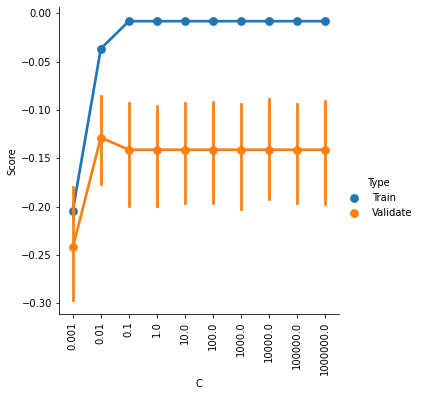

In [93]:
# and plot the results

g = sns.catplot(x='C',y='Score',hue='Type',data=ValCurves,kind='point')
plt.xticks(range(10))
g.set_xticklabels(C_range, rotation=90)

It looks like accuracy is better for higher values of `C`, and plateaus somewhere between 0.1 and 1.

The default setting is `C=1`, so it looks like we can't really improve much by changing `C`.

But our SVR model actually has two hyperparameters, `C` and `epsilon`. Perhaps there is an optimal combination of settings for these two parameters.

We can explore that somewhat quickly with a `grid search`, which is once again easily achieved with `sklearn`.

Because we are fitting the model multiple times witih cross-validation, this will take some time ...


### Let's tune some hyperparameters

In [75]:
from sklearn.model_selection import GridSearchCV

C_range = 10. ** np.arange(-3, 8)
epsilon_range = 10. ** np.arange(-3, 8)

param_grid = dict(epsilon=epsilon_range, C=C_range)

grid = GridSearchCV(lin_svr, param_grid=param_grid, cv=10)

grid.fit(X_train, y_train_log)

GridSearchCV(cv=10, estimator=SVR(kernel='linear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07]),
                         'epsilon': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04,
       1.e+05, 1.e+06, 1.e+07])})

Now that the grid search has completed, let's find out what was the "best" parameter combination

In [77]:
print(grid.best_params_)

{'C': 0.01, 'epsilon': 0.01}


And if redo our cross-validation with this parameter set?

In [79]:
y_pred = cross_val_predict(SVR(kernel='linear',
                               C=grid.best_params_['C'],
                               epsilon=grid.best_params_['epsilon'], 
                               gamma='auto'), 
                           X_train, y_train_log, cv=10)

# scores
acc = r2_score(y_train_log, y_pred)
mae = mean_absolute_error(y_train_log,y_pred)

In [83]:
# print model performance
print('R2:', acc)
print('MAE:', mae)

R2: 0.6918967934598623
MAE: 0.26595760648195826


Text(0, 0.5, 'Log Age')

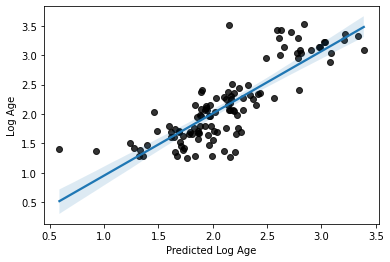

In [85]:
# and plot the results
sns.regplot(x=y_pred, y=y_train_log, scatter_kws=dict(color='k'))
plt.xlabel('Predicted Log Age')
plt.ylabel('Log Age')

Perhaps unsurprisingly, the model fit is only very slightly improved from what we had with our defaults. **There's a reason they are defaults, you silly**

Grid search can be a powerful and useful tool. But can you think of a way that, if not properly utilized, it could lead to overfitting? Could it be happening here?

You can find a nice set of tutorials with links to very helpful content regarding how to tune hyperparameters while being aware of over- and under-fitting here:

https://scikit-learn.org/stable/modules/learning_curve.html
